In [525]:
import os
import re
import io
import gzip
import requests
import itertools
import pandas as pd
import geopandas as gpd
import hashlib
import numpy as np
import requests
from statistics import NormalDist
import matplotlib.pyplot as plt
from copy import deepcopy
from concurrent.futures import ThreadPoolExecutor, as_completed
import scipy.stats as st
import seaborn as sns

In [526]:
modelling_svc_url = "http://localhost:8888" # https://farmdb.climatefarmers.org/api/models

In [532]:
def model_run(params: dict):
    url = modelling_svc_url + "/rothc/"
    response = requests.request("POST", url, json=params)
    return response.json()['data']

def confidence_interval(data, conf=0.9):
    """ Computes the confidence interval of an input distribution using either t-score or z-score 
    depending on the available number of samples """
    if len(data) >= 30:
        return st.norm.interval(alpha=conf, loc=np.mean(data), scale=st.sem(data))
    return st.t.interval(alpha=conf, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 

def sample(data, intervals=[0.9]):
    mean = np.mean(data)
    bounds = {}
    for i in intervals: 
        low, upp = confidence_interval(data, i)
        bounds[f'lower_{i}'] = low
        bounds[f'upper_{i}'] = upp
    return {
        'mean': mean,
        **bounds
    }

def weihermueller_init(soc, clay):
    """ Implements the initialization pedotransfer functions as described for IOM in Falloon (1998) 
    [10.1016/S0038-0717(97)00256-3] and for RPM, HUM and BIO in Weihermueller (2013) [10.1111/ejss.12036].
    DPM is ignored here since it a relatively small and volatile pool, 
    only added during growing season during the model runs """
    iom = 0.049 * soc ** 1.139
    rpm = (0.1847 * soc + 0.1555) * (clay + 1.2750) ** -0.1158
    hum = (0.7148 * soc + 0.5069) * (clay + 0.3421) ** 0.0184
    bio = (0.0140 * soc + 0.0075) * (clay + 8.8473) ** 0.0567
    return {
        'DPM': 0.,
        'RPM': rpm,
        'BIO': bio,
        'HUM': hum,
        'IOM': iom
    }

In [533]:
params = {
    "desc" : "Test",
    "location" : "Nowhere",
    "crop" : "Sorghum",
    "temp_adjustment" : 0,
    "soil_thick" : 25,
    "c_in" : 7.56,
    "fym_in" : 1,
    "pE" : 1,
    "time_horizon" : 10, 
    "bare_profile" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "SOC_target" : 30
}

#### 5 variables with upper and lower bounds: 

- soc
- clay
- evap
- precip
- temp

For the climate factors (evap, precip, temp) I propose taking the monthly lower and upper bounds and concatenating them into an overall upper/lower bound year rather than going the extra 100 miles and computing 3 x 2^12 scenarios

#### Nr. of pool scenarios: 

4:  Computed respectively for soc & clay, UU, LL, UL, LU

#### Total number of combinations: 

For each pool, we vary clay, evap, precip and temp. We don't need to vary soc since it is not a direct input and only needed to initialize the pools.

4 x 2^4 = 64


# Loading temp, prec and evap bounds

To be prepared in Data Acquisition notebook

In [597]:
temp_bounds_path = 'temp_bounds_0.9_meteostat.csv'
prec_bounds_path = 'prec_bounds_0.9_meteostat.csv'
evap_bounds_path = 'evap_bounds_0.9_dwd.csv'

temp_bounds = pd.read_csv(temp_bounds_path)
prec_bounds = pd.read_csv(prec_bounds_path)
evap_bounds = pd.read_csv(evap_bounds_path)

In [599]:
soc_samples = [40, 42, 45, 58, 41]
clay_samples = [20, 32, 18, 42, 36]

soc_bounds = sample(soc_samples, [0.9, 0.5])
clay_bounds = sample(clay_samples, [0.9, 0.5])

# Compute the possible initial pool configurations:

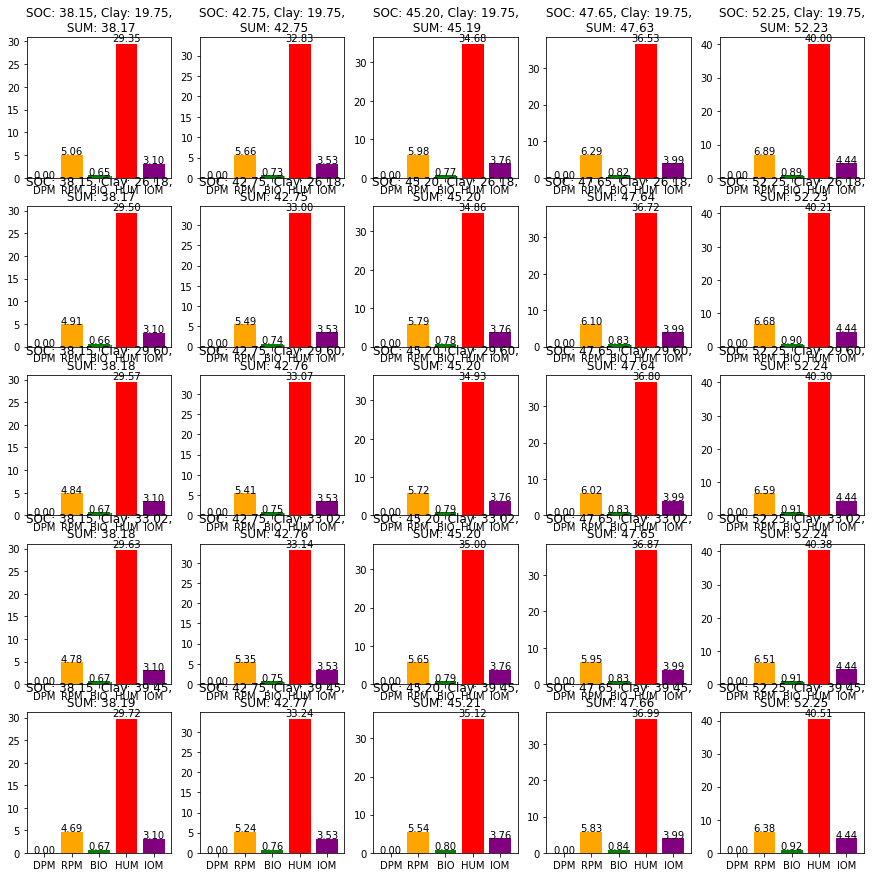

In [611]:
combinations = list(itertools.product(range(5), repeat=2))
label = lambda x: ['lower_0.9', 'lower_0.5', 'mean', 'upper_0.5', 'upper_0.9'][x]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,15))

pools = []
for i, c in enumerate(combinations):
    p = i%5
    q = i//5
    # Picking the respective bound
    soc = soc_bounds[label(c[0])]
    clay = clay_bounds[label(c[1])]
    
    # Initializing pools
    pool = weihermueller_init(soc, clay)
    pools.append(pool)
    
    # Plotting
    ax[p,q].bar(height=[v for k,v in pool.items()], 
              x=list(pool.keys()),
              color=['blue', 'orange', 'green', 'red', 'purple'])
    ax[p,q].set_title(f"SOC: {soc:.2f}, Clay: {clay:.2f},\n SUM: {sum(v for _,v in pool.items()):.2f}")
    for patch in ax[p,q].patches:
        width = patch.get_width()
        height = patch.get_height()
        x, y = patch.get_xy() 
        ax[p,q].annotate(f'{height:.2f}', (x + width/2, y + height*1.02), ha='center')

plt.show()

# Prepare the other combinations

In [617]:
combinations = list(itertools.product(range(5), repeat=4))
short = lambda x: ['L', 'S', 'M', 'B', 'U'][x]


scenarios = []
for i, pool in enumerate(pools): 
    for c in combinations:
        clay = clay_bounds[label(c[0])]
        temp = temp_bounds[label(c[1])].values.tolist()
        prec = prec_bounds[label(c[2])].values.tolist()
        evap = evap_bounds[label(c[3])].values.tolist()
        scenario_id = hashlib.md5(f"{clay}{temp}{prec}{evap}".encode()).hexdigest()
        scenarios.append({
            'clay': clay,
            'temp': temp,
            'precip': prec,
            'evap':evap,
            'SOC_pools': pool,
            'id': scenario_id,
            'desc': f"{short(c[0])}C_{short(c[1])}T_{short(c[2])}P_{short(c[3])}E_{i}pool"
        })
        
print(f"Created {len(scenarios)} scenarios")

Created 15625 scenarios


# Submit combinations to modeling endpoint

We're using multithreading to speed things up a bit

In [618]:
workers = 16

res = []
with ThreadPoolExecutor(max_workers=workers) as pool:
    futures = {}
    for scenario in scenarios:
        scenario_params = {**params, **scenario}
        futures[pool.submit(model_run, scenario_params)] = scenario_params
    for future in as_completed(futures):
        p = futures[future]
        res.append({'params': p, 'result':future.result()})
    

In [625]:
import pickle
with open("big_run_out.pkl", "wb") as f:
    pickle.dump(res, f)

# Analyzing the results

In [627]:
codes = {
    'L':0,
    'S':1, 
    'M':2, 
    'B':3, 
    'U':4
}
decode = lambda x: codes.get(x)

collection = []
for r in res:
    d = r['params']['desc']
    parts = d.split('_')
    collection.append({'Clay': decode(parts[0][0]),
     'Temp': decode(parts[1][0]),
     'Prec': decode(parts[2][0]),
     'Evap': decode(parts[3][0]),
     'pool': parts[4][0],
     'id': r['params']['id'],
     'initial': r['result']['TOTAL'][0],
     'final': r['result']['TOTAL'][-1],
     'diff': r['result']['TOTAL'][-1] - r['result']['TOTAL'][0]})

In [628]:
df = pd.DataFrame(collection)
df

,Clay,Temp,Prec,Evap,pool,id,initial,final,diff
0,0,0,0,0,0,ee48f2bd03aa9d11b3b1c6f2f2cc7ae3,38.169,63.355,25.186
1,0,0,1,2,0,b3b4a16d974028e90f5a2c46d84498b2,38.169,59.763,21.594
2,0,0,1,3,0,fbebf69b66a5fac772d018f3380f36ed,38.169,60.940,22.771
3,0,0,0,4,0,11921aa6c0c21261c1755860f1b0e87a,38.169,65.513,27.344
4,0,0,2,3,0,ec35b4e65bff3e98643ad2739bec6cd0,38.169,53.529,15.360
...,...,...,...,...,...,...,...,...,...
15620,4,4,4,3,2,aaf4d3330f7c62b95641aef50f62fee9,52.253,57.720,5.467
15621,4,4,3,3,2,ba92d177b8eb45b889e36b7377f13172,52.253,58.074,5.821
15622,4,4,4,0,2,4cf33d0e5d92df65ece81db53469a34a,52.253,57.720,5.467
15623,4,4,3,4,2,78e77e4fa354b32906a71fbc86c58714,52.253,58.212,5.959


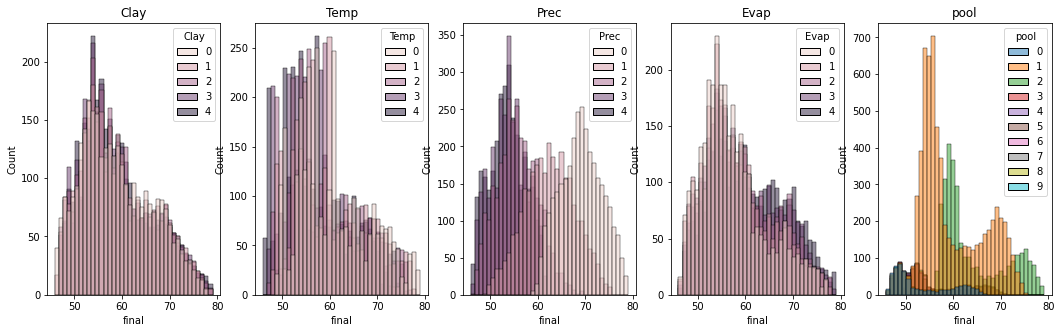

In [648]:
fig, ax = plt.subplots(ncols=5, figsize=(18,5))
for i, l in enumerate(['Clay', 'Temp', 'Prec', 'Evap', 'pool']):
    sns.histplot(data=df, x='final', hue=l, ax=ax[i]).set_title(l)
plt.show()

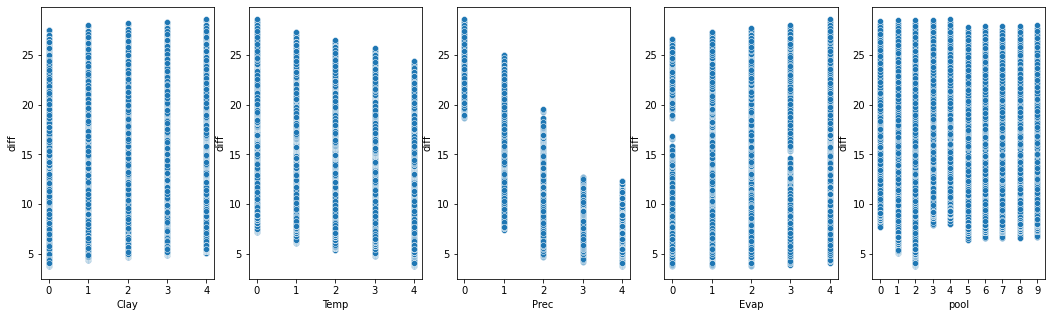

In [658]:
fig, ax = plt.subplots(ncols=5, figsize=(18,5))
for i, l in enumerate(['Clay', 'Temp', 'Prec', 'Evap', 'pool']):
    sns.scatterplot(data=df, x=l, y='diff', ax=ax[i])
plt.show()

In [631]:
lower_s = df[df['final'] == df['final'].min()]
upper_s = df[df['final'] == df['final'].max()]

In [632]:
lower_s

,Clay,Temp,Prec,Evap,pool,id,initial,final,diff
117,0,4,4,0,0,f7946dd55583815ef6b98561e68dd237,38.169,45.933,7.764
126,0,4,4,1,0,c6947be8fba0faff35e16f515c8e4f6c,38.169,45.933,7.764


In [633]:
upper_s

,Clay,Temp,Prec,Evap,pool,id,initial,final,diff
15504,4,0,0,4,2,4cbe437ad8de73ebd95e932bd5bf403e,52.253,78.999,26.746


# Run the actual mean modelling scenario

In [634]:
# Use mean of all parameter distributions
soc = soc_bounds['mean']
clay = clay_bounds['mean']
temp = temp_bounds['mean'].values.tolist()
prec = prec_bounds['mean'].values.tolist()
evap = evap_bounds['mean'].values.tolist()
scenario_id = hashlib.md5(f"{clay}{temp}{prec}{evap}".encode()).hexdigest()

# Initializing pools
pool = weihermueller_init(soc, clay)

mean_params = {
        'clay': clay,
        'temp': temp,
        'precip': prec,
        'evap':evap,
        'SOC_pools': pool,
        'id': scenario_id,
        'desc': f"main"
    }

scenario_params = {**params, **mean_params}
main = pd.DataFrame(model_run(scenario_params))

# Aggregate all results into single DataFrame

In [619]:
dfs = []
for r in res:
    df = pd.DataFrame(r['result'])
    df['month'] = list(range(12)) * params['time_horizon']
    df['year'] = np.arange(params['time_horizon']).repeat(12)
    df['count'] = np.arange(120)
    df['id'] = r['params']['id']
    dfs.append(df)

all_scen = pd.concat(dfs, axis=0)

In [641]:
all_scen

,DPM,RPM,BIO,HUM,IOM,TOTAL,month,year,count,id
0,0.000,5.061,0.655,29.352,3.101,38.169,0,0,0,ee48f2bd03aa9d11b3b1c6f2f2cc7ae3
1,0.392,5.343,0.655,29.352,3.101,38.842,1,0,1,ee48f2bd03aa9d11b3b1c6f2f2cc7ae3
2,0.690,5.608,0.663,29.359,3.101,39.421,2,0,2,ee48f2bd03aa9d11b3b1c6f2f2cc7ae3
3,0.804,5.839,0.686,29.384,3.101,39.814,3,0,3,ee48f2bd03aa9d11b3b1c6f2f2cc7ae3
4,0.931,6.077,0.708,29.408,3.101,40.226,4,0,4,ee48f2bd03aa9d11b3b1c6f2f2cc7ae3
...,...,...,...,...,...,...,...,...,...,...
115,0.185,8.572,1.314,42.716,4.437,57.224,7,9,115,4713c63f69a2acbcf6207c69dc18b4f6
116,0.219,8.380,1.280,42.705,4.437,57.022,8,9,116,4713c63f69a2acbcf6207c69dc18b4f6
117,0.298,8.345,1.266,42.707,4.437,57.052,9,9,117,4713c63f69a2acbcf6207c69dc18b4f6
118,0.439,8.448,1.266,42.717,4.437,57.308,10,9,118,4713c63f69a2acbcf6207c69dc18b4f6


In [620]:
all_scen.to_csv('big_run_out.csv', index=False)

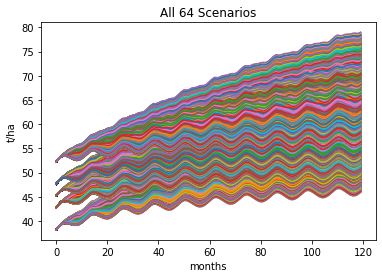

In [621]:
fig, ax = plt.subplots()
ax.set_title("All 64 Scenarios")
ax.set_ylabel("t/ha")
ax.set_xlabel("months")
for df in dfs:
    df['TOTAL'].plot(ax=ax)
plt.show()

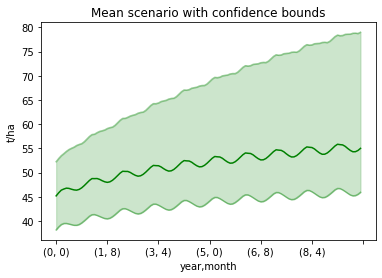

In [635]:
low_upp = all_scen.groupby(['year','month'])['TOTAL'].agg(['min', 'max'])
fig, ax = plt.subplots()
ax.set_title("Mean scenario with confidence bounds")
ax.set_ylabel("t/ha")
ax.set_xlabel("months")
low_upp.plot(ax=ax, c='green', legend=False, alpha=0.4)
main['TOTAL'].plot(ax=ax, c='green')
ax.fill_between(np.arange(12*params['time_horizon']),low_upp['min'], low_upp['max'], color='g',alpha=0.2)
plt.show()

# Correlation Analysis

In [637]:
df[['Clay', 'Temp', 'Prec', 'Evap', 'diff']].corr().round(2)

,Clay,Temp,Prec,Evap,diff
Clay,1.0,0.00,-0.00,-0.00,0.00
Temp,0.0,1.00,-0.00,-0.00,-0.19
Prec,-0.0,-0.00,1.00,-0.00,-0.87
Evap,-0.0,-0.00,-0.00,1.00,0.18
diff,0.0,-0.19,-0.87,0.18,1.00


# Decision Tree feature Importance

In [638]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor().fit(df[['Clay', 'Temp', 'Prec', 'Evap', 'pool']], df['diff'])
[print(f"{f}: {i:.3f}") for f,i in zip(['Clay', 'Temp', 'Prec', 'Evap', 'pool'],tree.feature_importances_)]

Clay: 0.007
Temp: 0.036
Prec: 0.870
Evap: 0.071
pool: 0.016


[None, None, None, None, None]